In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
from catboost import CatBoostClassifier, Pool

In [3]:
root_dir = os.path.dirname(os.getcwd())
display(root_dir)
data_dir = os.path.join(root_dir, 'data')
display(data_dir)
train_path = os.path.join(data_dir, 'train.xlsx')
display(train_path)
test_path = os.path.join(data_dir, 'test.xlsx')
display(test_path)
catboost_res_dir = os.path.join(root_dir, 'catboost_res')
display(catboost_res_dir)

'C:\\Users\\32233\\OneDrive\\Documents\\HSE\\AI\\projects\\PSB_hack'

'C:\\Users\\32233\\OneDrive\\Documents\\HSE\\AI\\projects\\PSB_hack\\data'

'C:\\Users\\32233\\OneDrive\\Documents\\HSE\\AI\\projects\\PSB_hack\\data\\train.xlsx'

'C:\\Users\\32233\\OneDrive\\Documents\\HSE\\AI\\projects\\PSB_hack\\data\\test.xlsx'

'C:\\Users\\32233\\OneDrive\\Documents\\HSE\\AI\\projects\\PSB_hack\\catboost_res'

In [4]:
df = pd.read_excel(train_path)
display(df.head())

,Unnamed: 0,№ брони,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Дата отмены,Заезд,Ночей,Выезд,Источник,Статус брони,Категория номера,Гостей,Гостиница
0,0,20230428-6634-194809261,1,25700.0,0,Внешняя система оплаты,2023-04-20 20:37:30,2023-04-20 20:39:15,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Отмена,Номер «Стандарт»,2,1
1,1,20220711-6634-144460018,1,24800.0,12400,Отложенная электронная оплата: Банк Россия (ба...,2022-06-18 14:17:02,NaT,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,1
2,2,20221204-16563-171020423,1,25800.0,12900,Банк. карта: Банк Россия (банк. карта),2022-11-14 22:59:30,NaT,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Активный,Номер «Студия»,2,4
3,3,20230918-7491-223512699,1,10500.0,0,Внешняя система оплаты (С предоплатой),2023-09-08 15:55:53,NaT,2023-09-18 15:00:00,1,2023-09-19 12:00:00,Bronevik.com(new),Активный,Номер «Стандарт»,1,3
4,4,20230529-6634-200121971,1,28690.0,28690,Система быстрых платежей: Эквайринг ComfortBoo...,2023-05-20 19:54:13,NaT,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Активный,Номер «Люкс»,4,1


In [5]:
import random


def augment_data(data, num_augmentations=10):
    augmented_data = []

    for _, row in data.iterrows():
        for _ in range(num_augmentations):
            # Дублируем строку
            augmented_row = row.copy()

            # 1. Аугментация значений "Стоимость" и "Внесена предоплата"
            # Изменяем значения с заданной вероятностью
            if random.random() < 0.2:
                augmented_row["Стоимость"] = int(augmented_row["Стоимость"] * (1 + random.uniform(-0.1, 0.1)))
                augmented_row["Внесена предоплата"] = int(
                    augmented_row["Внесена предоплата"] * (1 + random.uniform(-0.1, 0.1)))

            # 2. Аугментация значений "Способ оплаты"
            # Заменяем значение с заданной вероятностью
            if random.random() < 0.1:
                payment_methods = ["Банк. карта: Банк Россия (банк. карта)", "Оплата наличными", "Электронная оплата"]
                augmented_row["Способ оплаты"] = random.choice(payment_methods)

            # 3. Аугментация значений "Источник"
            # Заменяем значение с заданной вероятностью
            if random.random() < 0.1:
                sources = ["Официальный сайт", "Партнерская программа", "Рекламная кампания", "Социальные сети"]
                augmented_row["Источник"] = random.choice(sources)

            # 4. Аугментация значений "Категория номера"
            # Заменяем значение с заданной вероятностью
            if random.random() < 0.1:
                room_categories = ["Номер «Стандарт»", "Номер «Студия»", "Номер «Люкс»", "Номер «Семейный»"]
                augmented_row["Категория номера"] = random.choice(room_categories)

            augmented_data.append(augmented_row)

    # Создание нового DataFrame с аугментированными данными
    augmented_df = pd.DataFrame(augmented_data)

    return augmented_df

In [6]:
# df = augment_data(df,3)

In [7]:
tdf = pd.read_excel(test_path)
display(tdf.head())

,Unnamed: 0,№ брони,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница
0,0,20231129-16563-238946689,1,23750.0,23750,Банк. карта: Банк Россия (банк. карта),2023-11-28 10:34:43,2023-11-29 15:00:00,2,2023-12-01 12:00:00,Официальный сайт,Номер «Студия»,3,4
1,1,20221219-7491-174959103,1,15010.0,7505,Банк. карта: Банк Россия (банк. карта),2022-12-12 18:30:43,2022-12-19 15:00:00,2,2022-12-21 12:00:00,Официальный сайт,Номер «Стандарт»,2,3
2,2,20221211-6634-172724329,1,8400.0,8400,Отложенная электронная оплата: Банк Россия (ба...,2022-11-25 22:03:59,2022-12-11 15:00:00,1,2022-12-12 12:00:00,Официальный сайт,Номер «Стандарт»,2,1
3,3,20230821-6634-212247350,1,42500.0,42500,Банк. карта: Банк Россия (банк. карта),2023-07-18 15:45:46,2023-08-21 15:00:00,3,2023-08-24 12:00:00,Официальный сайт,Апартаменты с 2 спальнями с отдельным входом,4,1
4,4,20230326-6634-189784563,1,62500.0,11900,Система быстрых платежей: Эквайринг ComfortBoo...,2023-03-23 11:04:13,2023-03-26 15:00:00,5,2023-03-31 12:00:00,Официальный сайт,Номер «Стандарт»,1,1


In [8]:
target = df['Дата отмены'].notna().astype(int)
display(target)

0        1
1        0
2        0
3        0
4        0
        ..
26169    0
26170    0
26171    0
26172    1
26173    0
Name: Дата отмены, Length: 26174, dtype: int32

In [9]:
categorical_features = []

In [10]:
from sklearn.preprocessing import MinMaxScaler


def pre_proc(df, is_train=True):
    global categorical_features
    scaler = MinMaxScaler()
    # Removing number + data cancelation
    if is_train:
        df.drop(['Unnamed: 0', '№ брони', 'Статус брони'], axis=1, inplace=True)
    else:
        df.drop(['Unnamed: 0', '№ брони'], axis=1, inplace=True)
    # Conversation to region
    df['Гостиница'] = (df['Гостиница'] >= 3).astype(int)
    # Creating new features
    df['delta'] = (df['Заезд'] - df['Дата бронирования']).dt.days
    df['month'] = df['Дата бронирования'].dt.month
    df['weekday'] = df['Дата бронирования'].dt.weekday
    # Converting to timestamp
    df['Дата бронирования'] = df['Дата бронирования'].values.astype(np.int64) // 10 ** 9
    df['Заезд'] = df['Заезд'].values.astype(np.int64) // 10 ** 9
    # Drop checkout
    df.drop('Выезд', axis=1, inplace=True)
    # One hot for place-type
    place_type = ['Стандарт', 'Люкс', 'Апартаменты', 'Студия', 'Коттедж']
    for t in place_type:
        df[t] = df['Категория номера'].str.contains(t).astype(int)
    df.drop('Категория номера', axis=1, inplace=True)
    
    # From statistic bufs
    df['payment_diff'] = abs(df['Стоимость'] - df['Внесена предоплата'])
    df['payment_attitude'] = df['Внесена предоплата'] / df['Стоимость']
    # Normalization
    columns = ['Стоимость', 'Внесена предоплата', 'Заезд', 'Дата бронирования']
    df[columns] = scaler.fit_transform(df[columns])
    # HZHZH
    #df['Источник'] = df['Источник'].str.contains('Яндекс').astype(int)
    #df['Способ оплаты'] = df['Способ оплаты'].str.contains('Внешняя').astype(int)
    categorical_features = ["Ночей", "Номеров", "month", "weekday", 'Источник', 'Способ оплаты']
    return df

In [11]:
df = pre_proc(df, is_train=True)
df.drop('Дата отмены', axis=1, inplace=True)
display(df.head())

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Источник,Гостей,Гостиница,delta,month,weekday,Стандарт,Люкс,Апартаменты,Студия,Коттедж,payment_diff,payment_attitude
0,1,0.026053,0.000000,Внешняя система оплаты,0.650534,0.502607,3,Яндекс.Путешествия,2,0,7,4,3,1,0,0,0,0,25700.0,0.0
1,1,0.025141,0.021215,Отложенная электронная оплата: Банк Россия (ба...,0.230831,0.199166,2,Официальный сайт,2,0,23,6,5,1,0,0,0,0,12400.0,0.5
2,1,0.026155,0.022070,Банк. карта: Банк Россия (банк. карта),0.435517,0.351408,2,Официальный сайт,2,1,19,11,0,0,0,0,1,0,12900.0,0.5
3,1,0.010644,0.000000,Внешняя система оплаты (С предоплатой),0.843492,0.651721,1,Bronevik.com(new),1,1,9,9,4,1,0,0,0,0,10500.0,0.0
4,1,0.029085,0.049085,Система быстрых платежей: Эквайринг ComfortBoo...,0.691605,0.534932,2,Официальный сайт,4,0,8,5,5,0,1,0,0,0,0.0,1.0


In [12]:
tdf = pre_proc(tdf, is_train=False)
display(tdf.head())

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Источник,Гостей,Гостиница,delta,month,weekday,Стандарт,Люкс,Апартаменты,Студия,Коттедж,payment_diff,payment_attitude
0,1,0.028816,0.041828,Банк. карта: Банк Россия (банк. карта),0.954281,0.715021,2,Официальный сайт,3,1,1,11,1,0,0,0,1,0,0.0,1.0000
1,1,0.016379,0.013218,Банк. карта: Банк Россия (банк. карта),0.473430,0.360082,2,Официальный сайт,2,1,6,12,0,1,0,0,0,0,7505.0,0.5000
2,1,0.006973,0.014794,Отложенная электронная оплата: Банк Россия (ба...,0.450322,0.351852,1,Официальный сайт,2,0,15,11,4,1,0,0,0,0,0.0,1.0000
3,1,0.055498,0.074850,Банк. карта: Банк Россия (банк. карта),0.772202,0.612140,3,Официальный сайт,4,0,33,7,1,0,0,1,0,0,0.0,1.0000
4,1,0.083958,0.020958,Система быстрых платежей: Эквайринг ComfortBoo...,0.611499,0.459877,5,Официальный сайт,1,0,3,3,3,1,0,0,0,0,50600.0,0.1904


In [13]:
model = CatBoostClassifier(eval_metric='AUC',max_depth = 10 )

In [14]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

X = df
y = target

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    train_pool = Pool(X_train, y_train, cat_features=categorical_features)
    val_pool = Pool(X_val, y_val, cat_features=categorical_features)

    model.fit(train_pool, eval_set=val_pool, plot=False, use_best_model=True, early_stopping_rounds=50)

    # Получаем AUC из истории обучения
    score = model.evals_result_['validation']['AUC'][-1]  # Последнее значение AUC
    scores.append(score)

# Выводим средний AUC
print(f"Средний AUC: {np.mean(scores)}")

Learning rate set to 0.067172
0:	test: 0.8415361	best: 0.8415361 (0)	total: 242ms	remaining: 4m 1s
1:	test: 0.8482275	best: 0.8482275 (1)	total: 336ms	remaining: 2m 47s
2:	test: 0.8470704	best: 0.8482275 (1)	total: 424ms	remaining: 2m 21s
3:	test: 0.8537356	best: 0.8537356 (3)	total: 517ms	remaining: 2m 8s
4:	test: 0.8551413	best: 0.8551413 (4)	total: 609ms	remaining: 2m 1s
5:	test: 0.8538876	best: 0.8551413 (4)	total: 643ms	remaining: 1m 46s
6:	test: 0.8537249	best: 0.8551413 (4)	total: 733ms	remaining: 1m 43s
7:	test: 0.8551404	best: 0.8551413 (4)	total: 816ms	remaining: 1m 41s
8:	test: 0.8539538	best: 0.8551413 (4)	total: 914ms	remaining: 1m 40s
9:	test: 0.8544258	best: 0.8551413 (4)	total: 960ms	remaining: 1m 35s
10:	test: 0.8557623	best: 0.8557623 (10)	total: 1.05s	remaining: 1m 34s
11:	test: 0.8554178	best: 0.8557623 (10)	total: 1.08s	remaining: 1m 28s
12:	test: 0.8543917	best: 0.8557623 (10)	total: 1.11s	remaining: 1m 24s
13:	test: 0.8540593	best: 0.8557623 (10)	total: 1.14s	rem

In [15]:
ans = model.predict_proba(tdf)[:, 1]

ans = pd.DataFrame(ans, columns=['apply_promo'])
ans.to_csv('istochnik10.csv', index=False, header=False)

In [16]:
display(ans)

,apply_promo
0,0.020735
1,0.038352
2,0.100776
3,0.108235
4,0.027709
...,...
11213,0.133221
11214,0.124088
11215,0.021387
11216,0.039198


array([[<Axes: title={'center': 'apply_promo'}>]], dtype=object)

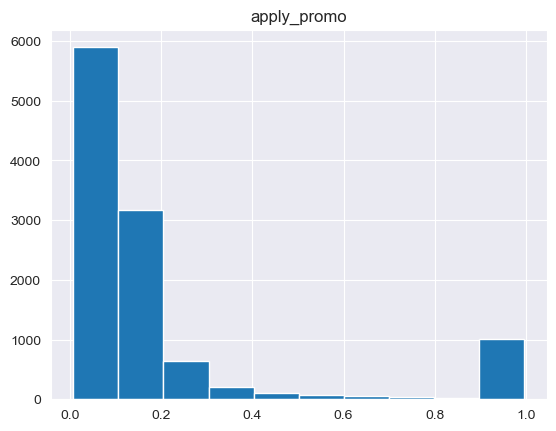

In [17]:
ans.hist()